In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
from utility import *

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTENC

from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, roc_auc_score, classification_report, ConfusionMatrixDisplay, roc_curve
import shap
import warnings

%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('data_with_seg.csv')

In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,segment
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,Segment 3
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,Segment 2
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,Segment 1
3,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no,Segment 3
4,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no,Segment 3


# Classification Model <a class="anchor" id="Classification"></a>

First, variables **duration** and **day** were dropped
- we won't be able to see the call duration until the actual call is being made.  
- creating dummy variables for **day** will generate too many variables

For classification exercise, I experimented with the below three models;
- Logistic Regression
- Random Forest with SMOTENC
- XGBoost

From initial experiment with these algorthims, I have noticed that the random forest algorithm suffered from the data imbalance and did poorly predicting minority class. Hence, I used the SMOTE (Synthetic Minority Oversampling Technique) method to create synthetic data that is close to existing data points but not exactly the same. This way, I was able to feed in more balanced data into random forest algorithm and improve the model performance, especially in prediciting the minority class.

In [4]:
# Drop Variables
model_data = data.drop(['duration','day'], axis = 1)

In [5]:
model_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,campaign,pdays,previous,poutcome,y,segment
0,58,management,married,tertiary,no,2143,yes,no,unknown,may,1,-1,0,unknown,no,Segment 3
1,44,technician,single,secondary,no,29,yes,no,unknown,may,1,-1,0,unknown,no,Segment 2
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,may,1,-1,0,unknown,no,Segment 1
3,35,management,married,tertiary,no,231,yes,no,unknown,may,1,-1,0,unknown,no,Segment 3
4,28,management,single,tertiary,no,447,yes,yes,unknown,may,1,-1,0,unknown,no,Segment 3


In [6]:
X = model_data.drop('y', axis = 1)
lb = LabelBinarizer()
y = lb.fit_transform(model_data['y'])
y = y.ravel()
X_train_data, X_test_data, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

In [7]:
X_train_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,campaign,pdays,previous,poutcome,segment
14525,36,management,married,tertiary,no,1584,yes,no,cellular,jul,1,-1,0,unknown,Segment 3
38133,42,entrepreneur,married,secondary,no,707,no,no,cellular,jun,1,348,1,success,Segment 1
12348,29,services,single,secondary,no,1274,no,no,cellular,jul,1,-1,0,unknown,Segment 2
19129,33,technician,married,tertiary,no,8408,no,no,cellular,aug,2,-1,0,unknown,Segment 3
13137,35,services,divorced,secondary,no,-504,no,no,cellular,jul,1,-1,0,unknown,Segment 2


In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return X[self.columns]

In [9]:
numeric_pipeline = make_pipeline(DataFrameSelector(['age','balance','campaign','pdays','previous']))

cat_pipeline = make_pipeline(DataFrameSelector(['job', 'marital', 'education', 'default', 'housing',
                                                'loan', 'contact', 'poutcome', 'month']),#,'segment']),
                              OneHotEncoder(drop = 'first'))

preprocess_pipeline = FeatureUnion(transformer_list  =
                                  [('numerical pipeline', numeric_pipeline),
                                   ('categorical pipline', cat_pipeline)
                                  ])

In [10]:
X_train = preprocess_pipeline.fit_transform(X_train_data)
X_test = preprocess_pipeline.fit_transform(X_test_data)

In [11]:
class EstimatorSelection:
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

        
    def fit(self, X, y, cv=3, n_jobs=2, verbose=1, scoring=None, refit=True):
        for key in self.keys:
            if verbose:
                print("Running GridSearchCV for %s." % key)
            X_train = X
            y_train = y
            model = self.models[key]
            params = self.params[key]
            
            if key == 'RandomForestClassifier':
                print("Running SMOTE for Random Forest...")
                cat_cols = list(range(5,X.shape[1]))
                sm = SMOTENC(categorical_features=cat_cols, sampling_strategy = 'minority')
                X_train, y_train = sm.fit_resample(X, y)
            
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            
            gs.fit(X_train,y_train)
            self.grid_searches[key] = gs

            
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]
    
    
    def summary_plot(self, key, X_test, y_test):
        y_pred = self.grid_searches[key].predict(X_test)
        print(f'AUC of {key} on test dataset: {round(roc_auc_score(y_test, y_pred),3)}')
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(cm, display_labels = ['No Response', 'Response']).plot()
        plt.show()
        print(classification_report(y_test, y_pred))
    
    
    def decile_lift_chart(self, key, X_test, y_test):
        pred_proba = pd.DataFrame(self.grid_searches[key].predict_proba(X_test), columns=['Prob 0', 'Prob 1'])
        y_test_df = pd.DataFrame(y_test, columns = ['Actual Y'])
        
        fig, (ax1, ax2)= plt.subplots(1,2,figsize = (15,4))
        skplt.metrics.plot_cumulative_gain(y_test_df, pred_proba, ax = ax1)
        skplt.metrics.plot_lift_curve(y_test_df, pred_proba, ax = ax2)
        plt.show()

In [12]:
models = {
    'LogisticClassifier': LogisticRegression(max_iter=2500),
    'RandomForestClassifier': RandomForestClassifier(),
    'XgBoostClassifier': xgb.XGBRFClassifier(missing = None)
                                             #, scale_pos_weight = 87/13),
}

parameters = {
    'LogisticClassifier': {
        'class_weight' : ['balanced'],
        'penalty' : ['l1','l2'],
        'solver' : ['liblinear', 'lbfgs'],
        'tol' : [0.001, 0.01, 0.1],
        'C' : [0.01, 0.1, 1, 10]
    },
    
    'RandomForestClassifier': {
        'bootstrap': [True],
        'max_depth': [10, 20, 30],
        'max_features': ['sqrt'],
        'min_samples_leaf': [2, 4],
        'min_samples_split': [10],
        'n_estimators': [200, 350, 500]},
    
    'XgBoostClassifier':  {
        'objective' : ['binary:logistic'],
        'eval_metric' : ['aucpr'],
        'max_depth' : [10, 20, 30],
        'learning_rate': [0.25, 0.5, 0.75],
        'gamma' : [0.25, 0.5, 0.75],
        'scale_pos_weight' : [5, 7, 8]
    }
}

In [13]:
helper = EstimatorSelection(models, parameters)
helper.fit(X_train, y_train, scoring='roc_auc', n_jobs=4)

Running GridSearchCV for LogisticClassifier.
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  60 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed:   12.4s finished


Running GridSearchCV for RandomForestClassifier.
Running SMOTE for Random Forest...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:  7.9min finished


Running GridSearchCV for XgBoostClassifier.
Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   46.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 243 out of 243 | elapsed:  4.7min finished


AUC of LogisticClassifier on test dataset: 0.698


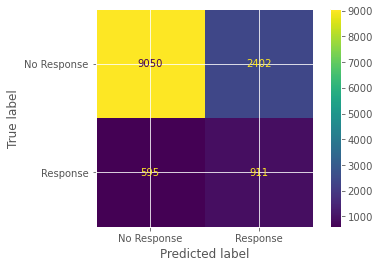

              precision    recall  f1-score   support

           0       0.94      0.79      0.86     11452
           1       0.27      0.60      0.38      1506

    accuracy                           0.77     12958
   macro avg       0.61      0.70      0.62     12958
weighted avg       0.86      0.77      0.80     12958



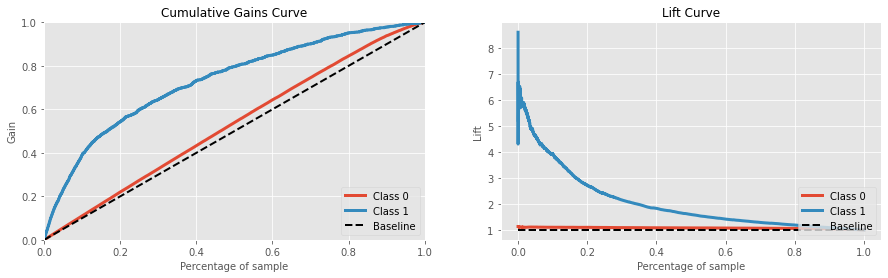

In [14]:
helper.summary_plot('LogisticClassifier', X_test, y_test)
helper.decile_lift_chart('LogisticClassifier', X_test, y_test)

AUC of RandomForestClassifier on test dataset: 0.629


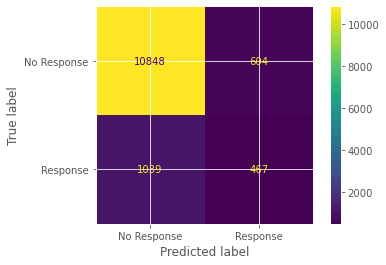

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     11452
           1       0.44      0.31      0.36      1506

    accuracy                           0.87     12958
   macro avg       0.67      0.63      0.65     12958
weighted avg       0.86      0.87      0.86     12958



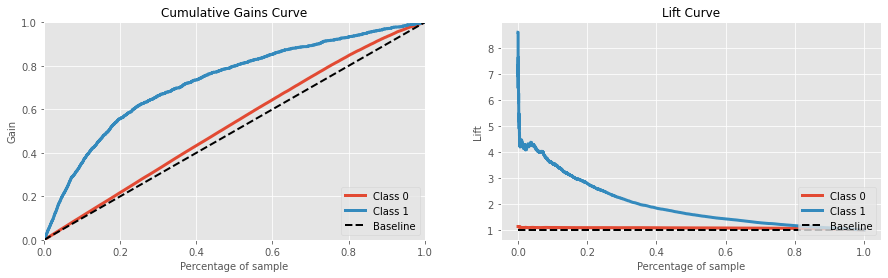

In [15]:
helper.summary_plot('RandomForestClassifier', X_test, y_test)
helper.decile_lift_chart('RandomForestClassifier', X_test, y_test)

AUC of XgBoostClassifier on test dataset: 0.694


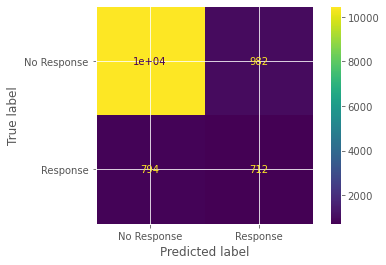

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     11452
           1       0.42      0.47      0.44      1506

    accuracy                           0.86     12958
   macro avg       0.67      0.69      0.68     12958
weighted avg       0.87      0.86      0.87     12958



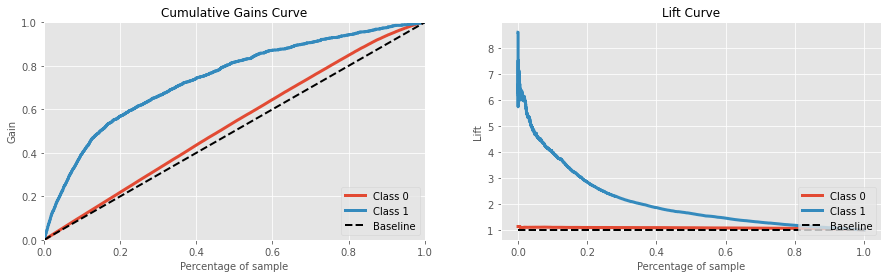

In [16]:
helper.summary_plot('XgBoostClassifier', X_test, y_test)
helper.decile_lift_chart('XgBoostClassifier', X_test, y_test)

In [17]:
explainer = shap.TreeExplainer(helper.grid_searches['XgBoostClassifier'].best_estimator_)
shap_values = explainer.shap_values(X_train)

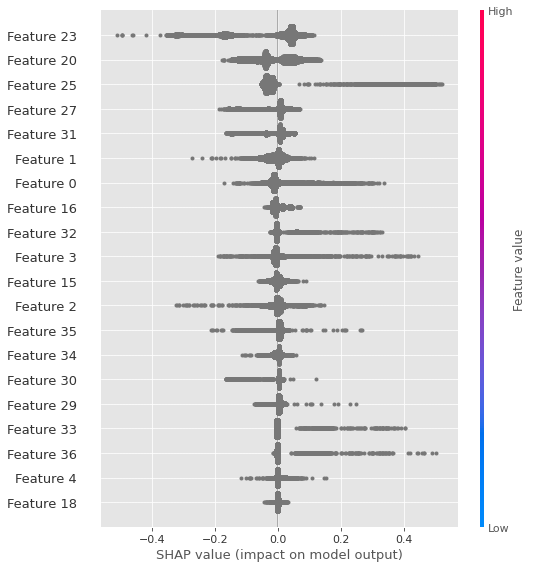

In [18]:
shap.summary_plot(shap_values, X_train)

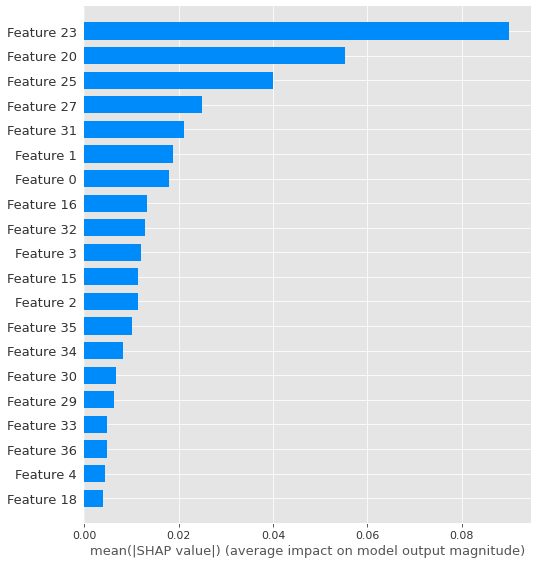

In [19]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

## Quick Experiment - Independent Models for each Segment
From the previous notebook, I conducted a segmentation analysis using K-Medoids with Gower's distance on the same dataset to see if there were different profiles of customers with different behaviors. In this experiment, three classification models used above were fitted to each of the three segments to test if there is any improvement as compared to fitting to the overall dataset. 

Theoretically, customer responses would vary depending on their age, financial status, etc and hence I expected the models for each segment to perform slightly better as compared models fitted to the entire dataset. However, the model performances are in line with the previous method (fitting to the entire dataset) and only marginal improvement was observed in the Logistic regression model. This is probably because of the large overlapping characteristics across segments (silouette score ~ 0.32) and thus segmentation fail to provide additional information for models to improve their performances. 

In [20]:
segments = np.sort(model_data.segment.unique())

In [21]:
segment_dict = {}
segment_x_test_dict = {}
segment_y_test_dict = {}

for i in segments:
    print(f'Modeling fitting for {i}')
    new_model_data = model_data[model_data['segment'] == i]
    
    X = new_model_data.drop(['segment','y'], axis = 1)
    lb = LabelBinarizer()
    y = lb.fit_transform(new_model_data['y'])
    y = y.ravel()
    X_train_data, X_test_data, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y)
    
    X_train = preprocess_pipeline.fit_transform(X_train_data)
    X_test = preprocess_pipeline.fit_transform(X_test_data)
    
    seg_model_fit = EstimatorSelection(models, parameters)
    seg_model_fit.fit(X_train, y_train, scoring='roc_auc', n_jobs=4)
    
    segment_dict[i] = seg_model_fit.grid_searches
    segment_x_test_dict[i] = X_test
    segment_y_test_dict[i] = y_test
#     for key in seg_model_fit.grid_searches.keys():
#         seg_model_fit.summary_plot(key, X_test, y_test)

Modeling fitting for Segment 1
Running GridSearchCV for LogisticClassifier.
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed:    4.9s finished


Running GridSearchCV for RandomForestClassifier.
Running SMOTE for Random Forest...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:  2.8min finished


Running GridSearchCV for XgBoostClassifier.
Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 243 out of 243 | elapsed:  1.7min finished


Modeling fitting for Segment 2
Running GridSearchCV for LogisticClassifier.
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 109 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed:    2.9s finished


Running GridSearchCV for RandomForestClassifier.
Running SMOTE for Random Forest...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   59.5s
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:  1.4min finished


Running GridSearchCV for XgBoostClassifier.
Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   47.0s
[Parallel(n_jobs=4)]: Done 243 out of 243 | elapsed:  1.0min finished


Modeling fitting for Segment 3
Running GridSearchCV for LogisticClassifier.
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 109 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed:    2.5s finished


Running GridSearchCV for RandomForestClassifier.
Running SMOTE for Random Forest...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:  1.4min finished


Running GridSearchCV for XgBoostClassifier.
Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   51.7s
[Parallel(n_jobs=4)]: Done 243 out of 243 | elapsed:  1.1min finished


AUC of LogisticClassifier on test dataset: 0.697


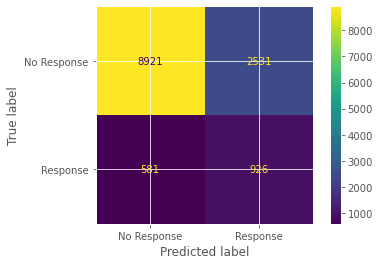

              precision    recall  f1-score   support

         0.0       0.94      0.78      0.85     11452
         1.0       0.27      0.61      0.37      1507

    accuracy                           0.76     12959
   macro avg       0.60      0.70      0.61     12959
weighted avg       0.86      0.76      0.80     12959

AUC of RandomForestClassifier on test dataset: 0.635


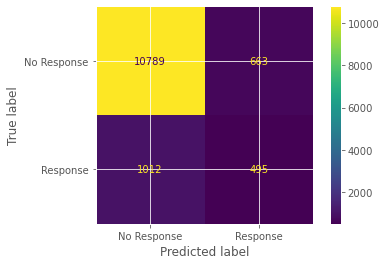

              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93     11452
         1.0       0.43      0.33      0.37      1507

    accuracy                           0.87     12959
   macro avg       0.67      0.64      0.65     12959
weighted avg       0.86      0.87      0.86     12959

AUC of XgBoostClassifier on test dataset: 0.681


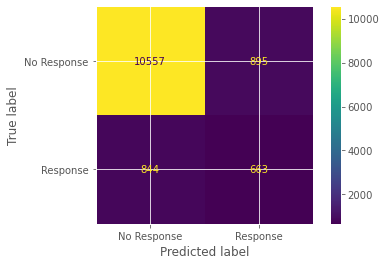

              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92     11452
         1.0       0.43      0.44      0.43      1507

    accuracy                           0.87     12959
   macro avg       0.68      0.68      0.68     12959
weighted avg       0.87      0.87      0.87     12959



In [22]:
for model in segment_dict['Segment 1'].keys():
    y_pred = np.array([])
    test_y = np.array([])
    for seg in segment_dict.keys():
        x_test = segment_x_test_dict[seg]
        temp_y = segment_y_test_dict[seg]
        temp = segment_dict[seg][model].predict(x_test)
        y_pred = np.append(y_pred, temp)
        test_y = np.append(test_y, temp_y)
            
    print(f'AUC of {model} on test dataset: {round(roc_auc_score(test_y, y_pred),3)}')
    cm = confusion_matrix(test_y, y_pred)
    ConfusionMatrixDisplay(cm, display_labels = ['No Response', 'Response']).plot()
    plt.show()
    print(classification_report(test_y, y_pred))